In [ ]:
import os
import numpy as np
import pandas as pd
import math
import cv2 as cv
import tqdm
import threading
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pickle

from PIL import Image
from pathlib import Path
from skimage.feature import hog
from tqdm import tqdm #add progress bars to loops and iterable objects.
from multiprocessing import Pool
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef


warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

#Connecting the driver
from google.colab import drive

drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
# Setting all the directories

root = '/content/drive/MyDrive/ML'
model = 'models'
#style_file = 'styles.csv'
image_folder_train = root + '/data/train/'
image_folder_train_o =image_folder_train + 'O/'
image_folder_train_r =image_folder_train + 'R/'

In [ ]:
# Feature Engineering using HoG
def get_all_image_names_and_its_class_to_df(folder_name):
    #print(folder_name)
    df_local=pd.DataFrame(columns=['id','masterCategory'])
    for folder in os.listdir(folder_name):
      #print(folder)
      if folder != '.DS_Store':
            folder_path =os.path.join(folder_name,folder)
            #print(folder_path)
            temp_df=pd.DataFrame(columns=['id','masterCategory'])
            img_list=[]
            for img in os.listdir(folder_path):
                img_list.append(img)
            #print(folder)
            temp_df['id'] =img_list
            temp_df['masterCategory']= folder
            #print(temp_df)
            df_local = pd.concat([df_local, temp_df], ignore_index=True)
    return df_local

# Loading the images
def load_image(ids, path):
    img = cv.imread(path + ids, cv.IMREAD_GRAYSCALE)
    return img, ids

def process_image(id_path_tuple):
    id, path = id_path_tuple
    img, id = load_image(id, path)
    if img is not None:
        return [img, id]

# resizing of images
def resize_image(img,ids):
    return cv.resize(img, (80, 80),interpolation =cv.INTER_LINEAR) # Tired with 60,80 # tired 60,60 # tired 100 by 100 system crash

#bluring the images
def hog_to_blur_the_images(image):
    ppcr = 7 # tired with 8,7,5
    ppcc = 7 # Tired with 8,7,5
    blur = cv.GaussianBlur(image, (5, 5), 0) #kernal size 7,8 checked , # larger kernel more blur # changes sigma from 0
    fd, hog_image = hog(blur, orientations=5, pixels_per_cell=(ppcr, ppcc), cells_per_block=(2, 2), block_norm='L2', visualize=True)
    return hog_image, fd

#get the edges
def get_edges(img_list,n_samples):
  edges = [cv.Canny(image,50,150,apertureSize = 3) for image in img_list]
  #edges = [cv.Canny(image, 50, 200, apertureSize=3) for image in img_list]
  #edges = [cv.Canny(image, 50, 250, apertureSize=3) for image in img_list]
  edges = np.array(edges)
  #print(edges)
  n_samples_edges = len(edges)
  edge_images_train = edges.reshape((n_samples, -1))
  edge_images_train.shape
  return edge_images_train

#pixel intensity
def get_pixel_intnsity(img_list):
  histr_train = [cv.calcHist([img],[0],None,[256],[0,256]) for img in img_list] # bin size,color channel
  #histr_train = [cv.calcHist([img],[0],None,[300],[0,300]) for img in img_list]
  histr_train = np.array(histr_train)
  n_samples_histr_train = len(histr_train)
  image_hist_train = histr_train.reshape((n_samples_histr_train, -1))
  image_hist_train.shape
  return image_hist_train


In [ ]:
#Multiproessing
# Mulitprocessing 1 --> Process Image
def create_a_multiprocessing(folder_name,df):
    df_ids = list(df.id)
    # Create a list of (id, path) tuples
    id_path_tuples = [(id, folder_name) for id in df_ids]
    # Create a multiprocessing pool
    pool = Pool(processes=8)
    # Process images in parallel
    results = list(tqdm(pool.imap(process_image, id_path_tuples), total=len(df_ids)))
    # Close the pool
    pool.close()
    pool.join()
    images= [result for result in results if result is not None]
    len(images)
    return images

# Multiprocessing 2 --> Blurring Image
def create_a_multiprocessing_blur(image_lst):
    pool = Pool(processes=5)
    hog_images, hog_features = zip(*pool.map(hog_to_blur_the_images, image_lst))
    pool.close()
    pool.join()

    hog_features = np.array(hog_features)
    return hog_images, hog_features

In [ ]:
# Loading all the images
df_train = get_all_image_names_and_its_class_to_df(image_folder_train)
print(df_train.shape)
print(df_train.head(10))
print(df_train['masterCategory'].value_counts())

(25077, 2)
           id masterCategory
0  R_9506.jpg              R
1  R_9613.jpg              R
2  R_9751.jpg              R
3  R_9872.jpg              R
4  R_9354.jpg              R
5  R_9943.jpg              R
6  R_9265.jpg              R
7  R_9280.jpg              R
8  R_9287.jpg              R
9  R_9210.jpg              R
O    13966
R    11111
Name: masterCategory, dtype: int64


In [ ]:
train_images_o =create_a_multiprocessing(image_folder_train_o,df_train)
train_images_r =create_a_multiprocessing(image_folder_train_r,df_train)
all_train_images = train_images_o+train_images_r
print("Length of train images",len(all_train_images))

100%|██████████| 25077/25077 [05:20<00:00, 78.37it/s]  


Length of train images 25077


In [ ]:
all_images_resized_train = [[resize_image(x,y),y] for x,y in all_train_images]
df_labels_train = pd.DataFrame(all_images_resized_train,columns=['image','id'])


In [ ]:
# Adding all the labels
target = 'masterCategory'
df_labels_train = pd.merge(df_labels_train,df_train,how='left',on=['id'])
df_labels_train = df_labels_train.fillna('Others')
df_labels_train['class'] = pd.factorize(df_labels_train[target])[0]
print("Data Shape: ", str(df_labels_train.shape))
print(df_labels_train[target].value_counts())

Data Shape:  (25077, 4)
O    13966
R    11111
Name: masterCategory, dtype: int64


In [ ]:
train_images = np.stack(df_labels_train.image.values,axis=0)
n_samples_train = len(train_images)
print(n_samples_train)
data_images_train = train_images.reshape((n_samples_train, -1))

25077


In [ ]:
hog_images_train, hog_features_train = create_a_multiprocessing_blur(train_images)

In [ ]:
#getting the edges
edge_images_train = get_edges(train_images,n_samples_train)

In [ ]:
train_images.shape, hog_features_train.shape, edge_images_train.shape


((25077, 80, 80), (25077, 2000), (25077, 6400))

In [ ]:
edge_hog_train = np.hstack([hog_features_train,edge_images_train]) #to stack the sequence of input arrays horizontally (i.e. column wise) to make a single array
edge_hog_train.shape

(25077, 8400)

In [ ]:
#getting pixel intensity
image_hist_train = get_pixel_intnsity(train_images)
image_hist_train.shape

(25077, 256)

In [ ]:
edge_hog = np.hstack([hog_features_train,edge_images_train,image_hist_train])
edge_hog.shape

(25077, 8656)

In [ ]:
del train_images #--> freeing up the space
del edge_hog
del image_hist_train
del create_a_multiprocessing
del create_a_multiprocessing_blur
del all_images_resized_train
del get_all_image_names_and_its_class_to_df
del get_edges
del hog_images_train
del get_pixel_intnsity
del train_images_o
del train_images_r


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn import datasets, svm, metrics
from sklearn import metrics
from sklearn.decomposition import PCA


In [ ]:
# Models
X_train, X_test, y_train, y_test = train_test_split(hog_features_train, df_train['masterCategory'], test_size=0.2, random_state=42)

#X_train, X_test, y_train, y_test = train_test_split(edge_hog, df_train['masterCategory'], test_size=0.2, random_state=42)

**KNN**

In [ ]:
def accuracy_measures(y_pred,y_test,pos):
  # Sensitivity (Recall)
    sensitivity = recall_score(y_test, y_pred, pos_label=pos)  # or pos_label='O' depending on your positive class
    #print("Sensitivity (Recall):", sensitivity)
    print(f"Sensitivity for class {pos}: {sensitivity}")

    # Precision
    precision = precision_score(y_test, y_pred, pos_label=pos)  # or pos_label='O' depending on your positive class
    #print("Precision for ", pos,precision)
    print(f"Precision for class {pos}: {precision}")


    # F1-score
    f1 = f1_score(y_test, y_pred, pos_label=pos)  # or pos_label='O' depending on your positive class
    #print("F1-score:", f1)
    print(f"F1-score for class {pos}: {f1}")

    #Overall
    sensitivity_overall = recall_score(y_test, y_pred, average='weighted')
    print('sensitivity Overall Data:',sensitivity_overall)
    precision_overall = precision_score(y_test, y_pred, average='weighted')
    print('Precision Overall Data:',precision_overall)
    f1_overall = f1_score(y_test, y_pred, average='weighted')
    print('F1 Score Overall Data:',f1_overall)



    # Cohen's Kappa statistic
    kappa = cohen_kappa_score(y_test, y_pred)
    print("Cohen's Kappa:", kappa)

    # Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_test, y_pred)
    print("Matthews Correlation Coefficient (MCC):", mcc)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
y_train.value_counts()

(20061, 2000) (20061,)
(5016, 2000) (5016,)


O    11218
R     8843
Name: masterCategory, dtype: int64

In [ ]:
# Testing with different values of K
test_accuracy = []
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
lst_of_k= [3,5,7,10,15,20,25]
for i in lst_of_k:
  print(i)
  classifier = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
  classifier.fit(X_scaled, y_train)
  y_pred = classifier.predict(scaler.transform(X_test))
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy:", accuracy)

3
Accuracy: 0.6351674641148325
5
Accuracy: 0.6403508771929824
7
Accuracy: 0.6443381180223285
10
Accuracy: 0.6489234449760766
15
Accuracy: 0.6529106858054227
20
Accuracy: 0.6511164274322169
25
Accuracy: 0.6523125996810207


In [ ]:
# Creating the Classifer for best Value of K =20
classifier = KNeighborsClassifier(n_neighbors=20, algorithm='brute')
classifier.fit(X_scaled, y_train)
test_accuracy = classifier.score(scaler.transform(X_test), y_test)
y_pred = classifier.predict(X_test)

Accuracy Measure For Recyleable
Sensitivity (Recall): 0.45215311004784686
Precision for class R: 1.0
F1-score for class R: 0.6227347611202636
sensitivity Overall Data: 0.45215311004784686
Precision Overall Data: 1.0
F1 Score Overall Data: 0.6227347611202636
Cohen's Kappa: 0.0
Matthews Correlation Coefficient (MCC): 0.0


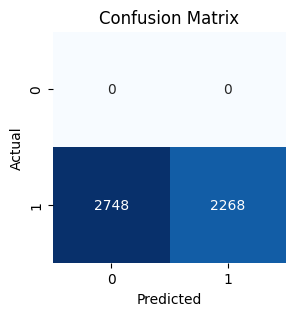

Accuracy Measure For Organic
Sensitivity (Recall): 0.0
Precision for class O: 0.0
F1-score for class O: 0.0
sensitivity Overall Data: 0.45215311004784686
Precision Overall Data: 1.0
F1 Score Overall Data: 0.6227347611202636
Cohen's Kappa: 0.0
Matthews Correlation Coefficient (MCC): 0.0


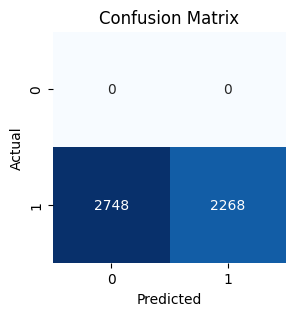

In [ ]:
print("Accuracy Measure For Recyleable")
accuracy_measures(y_test, y_pred,'R')
print("Accuracy Measure For Organic")
accuracy_measures(y_test, y_pred,'O')

Accuracy: 0.6511164274322169
Accuracy Measure For Recyleable
Sensitivity (Recall): 0.5968586387434555
Precision for class R: 0.7037037037037037
F1-score for class R: 0.6458923512747875
sensitivity Overall Data: 0.6511164274322169
Precision Overall Data: 0.658885872179751
F1 Score Overall Data: 0.6506997329489327
Cohen's Kappa: 0.306624555443495
Matthews Correlation Coefficient (MCC): 0.31067050182256334


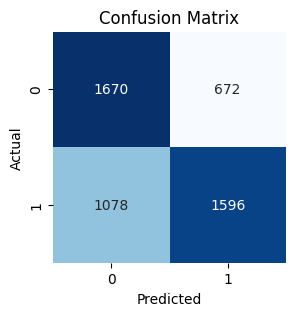

Accuracy Measure For Organic
Sensitivity (Recall): 0.713065755764304
Precision for class O: 0.6077147016011645
F1-score for class O: 0.656188605108055
sensitivity Overall Data: 0.6511164274322169
Precision Overall Data: 0.658885872179751
F1 Score Overall Data: 0.6506997329489327
Cohen's Kappa: 0.306624555443495
Matthews Correlation Coefficient (MCC): 0.31067050182256334


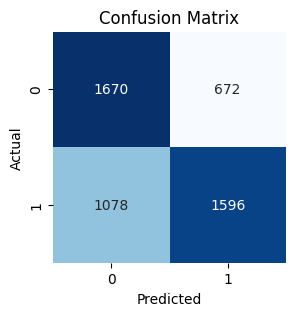

In [ ]:
# Applying PCA as the results were not good
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
n_components = 2000
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Initialize and train the KNN classifier
k_neighbors = 20
classifier = KNeighborsClassifier(n_neighbors=k_neighbors, algorithm='brute')
classifier.fit(X_train_pca, y_train)
y_pred = classifier.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Accuracy Measure For Recyleable")
accuracy_measures(y_test, y_pred,'R')
print("Accuracy Measure For Organic")
accuracy_measures(y_test, y_pred,'O')

In [ ]:
# Saved the model using Pickel

with open(os.path.join(root,model,'knn_model_brute.pkl'), 'wb') as knnPickle:
    pickle.dump(classifier, knnPickle)

with open(os.path.join(root,model,'train_features.pkl'), 'wb') as features_file:
    pickle.dump(X_train, features_file)

# Save hog_features_train
with open(os.path.join(root, model, 'hog_features_train.pkl'), 'wb') as hog_file:
    pickle.dump(hog_features_train, hog_file)

Image saved successfully ...
Data=pla.jfif, Predicted: ['R']


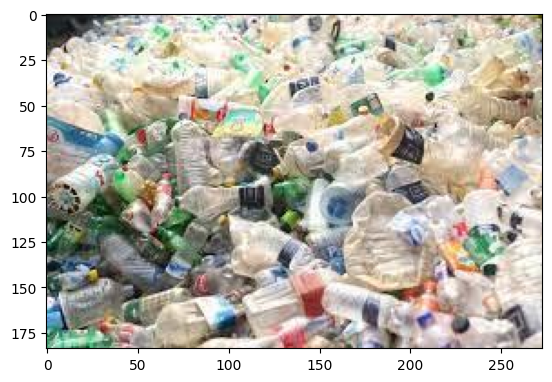

In [ ]:

n_components = 2000
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)

# Initialize and train the KNN classifier
k_neighbors = 20
classifier = KNeighborsClassifier(n_neighbors=k_neighbors, algorithm='brute')
classifier.fit(X_train_pca, y_train)

# New image path
test_image = 'test_image/'
image = "pla.jfif"
image_name = image.split('.')[0]
image_name = image_name + ".jpeg"
new_image_path = os.path.join(root, test_image, image)

# Converting the Image to JPEG
im = Image.open(new_image_path)
rgb_im = im.convert('RGB')
rgb_im.save(os.path.join(root, test_image, image_name))
print("Image saved successfully ...")

# Load and preprocess the new image
X_new = Image.open(os.path.join(root, test_image, image_name))
plt.imshow(X_new)
new_image = cv.imread(new_image_path, cv.IMREAD_GRAYSCALE)
new_image = cv.resize(new_image, (60, 80), interpolation=cv.INTER_LINEAR)

# Extract HOG features with 2000 dimensions
ppcr = 7
ppcc = 7
blur = cv.GaussianBlur(new_image, (7, 7), 1)
fd, hog_features = hog(blur, orientations=5, pixels_per_cell=(ppcr, ppcc), cells_per_block=(2, 2), block_norm='L2', visualize=True, feature_vector=True)
reshaped_features = hog_features.reshape(1, -1)

# Ensure reshaped_features has the same number of features as X_train_pca
if reshaped_features.shape[1] != X_train_pca.shape[1]:
    reshaped_features = reshaped_features[:, :X_train_pca.shape[1]]

# Scale and transform using PCA
new_image_pca = pca.transform(reshaped_features)

# Predict the label for the new image
predicted_class = classifier.predict(new_image_pca)

# Print the result
print(f"Data={image}, Predicted: {predicted_class}")


In [ ]:
"""classifier = KNeighborsClassifier(n_neighbors=20,algorithm='kd_tree')
classifier.fit(X_scaled, y_train)
test_accuracy = classifier.score(scaler.transform(X_test), y_test)
print(test_accuracy)"""

"""classifier = KNeighborsClassifier(n_neighbors=20,algorithm='ball_tree')
classifier.fit(X_scaled, y_train)
test_accuracy = classifier.score(scaler.transform(X_test), y_test)
print(test_accuracy)"""

In [ ]:
#Done with KNN

**Logistic regression**

Sensitivity for class R: 0.7151675485008818
Precision for class R: 0.6267387944358578
F1-score for class R: 0.6680395387149917
sensitivity Overall Data: 0.6786283891547049
Precision Overall Data: 0.6854672154767935
F1 Score Overall Data: 0.6792830321494321
Cohen's Kappa: 0.35921273860152314
Matthews Correlation Coefficient (MCC): 0.3621546476588085


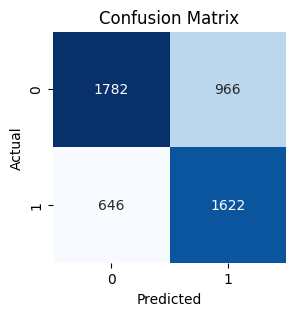

Sensitivity for class O: 0.648471615720524
Precision for class O: 0.7339373970345964
F1-score for class O: 0.6885625965996908
sensitivity Overall Data: 0.6786283891547049
Precision Overall Data: 0.6854672154767935
F1 Score Overall Data: 0.6792830321494321
Cohen's Kappa: 0.35921273860152314
Matthews Correlation Coefficient (MCC): 0.3621546476588085


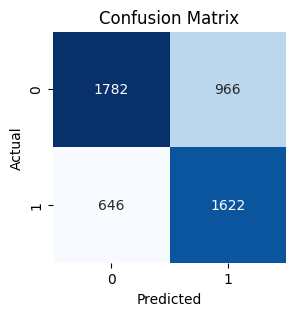

In [ ]:
#logistic regression training code
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

classifier = LogisticRegression(max_iter=7)
classifier.fit(X_scaled, y_train)

# Make predictions on the test set
y_pred = classifier.predict(scaler.transform(X_test))

# Calculate and print accuracy measures
accuracy_measures(y_pred, y_test, pos='R')
accuracy_measures(y_pred, y_test, pos='O')

Best Hyperparameters: {'C': 0.001, 'max_iter': 7}
Sensitivity (Recall): 0.7182539682539683
Precision for class R: 0.6279876638396299
F1-score for class R: 0.6700946112710818
sensitivity Overall Data: 0.6802232854864434
Precision Overall Data: 0.6872541742795323
F1 Score Overall Data: 0.680861960108147
Cohen's Kappa: 0.362538315851924
Matthews Correlation Coefficient (MCC): 0.3656198605432344


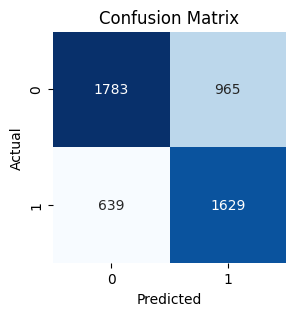

Sensitivity (Recall): 0.6488355167394468
Precision for class O: 0.736168455821635
F1-score for class O: 0.6897485493230174
sensitivity Overall Data: 0.6802232854864434
Precision Overall Data: 0.6872541742795323
F1 Score Overall Data: 0.680861960108147
Cohen's Kappa: 0.362538315851924
Matthews Correlation Coefficient (MCC): 0.3656198605432344


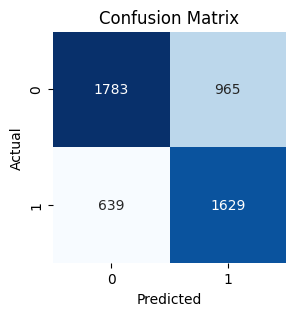

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and their possible values
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [7, 14, 21, 28, 35]
}

# Create a logistic regression classifier
classifier = LogisticRegression()

# Create a GridSearchCV object and fit it to the data
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_scaled, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Use the best model to make predictions on the test set
best_classifier = grid_search.best_estimator_
y_pred_best = best_classifier.predict(scaler.transform(X_test))

# Calculate and print accuracy measures for the best model
accuracy_measures(y_pred_best, y_test, pos='R')
accuracy_measures(y_pred_best, y_test, pos='O')


Best Hyperparameters: {'C': 0.15882940261657685, 'max_iter': 14}
Sensitivity (Recall): 0.5925925925925926
Precision for class R: 0.6339622641509434
F1-score for class R: 0.6125797629899726
sensitivity Overall Data: 0.6610845295055822
Precision Overall Data: 0.6596984468838673
F1 Score Overall Data: 0.6598126114608779
Cohen's Kappa: 0.3119834550707574
Matthews Correlation Coefficient (MCC): 0.3125446263734942


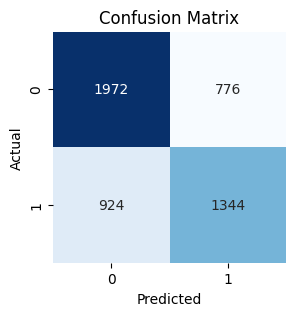

Sensitivity (Recall): 0.7176128093158661
Precision for class O: 0.680939226519337
F1-score for class O: 0.6987951807228915
sensitivity Overall Data: 0.6610845295055822
Precision Overall Data: 0.6596984468838673
F1 Score Overall Data: 0.6598126114608779
Cohen's Kappa: 0.3119834550707574
Matthews Correlation Coefficient (MCC): 0.3125446263734942


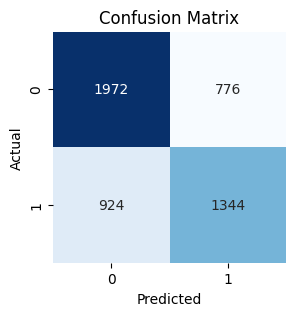

In [ ]:
from scipy.stats import uniform

# Define the hyperparameters and their possible distributions
param_dist = {
    'C': uniform(loc=0, scale=4),
    'max_iter': [7, 14, 21, 28, 35]
}

# Create a logistic regression classifier
classifier = LogisticRegression()

# Create a RandomizedSearchCV object and fit it to the data
random_search = RandomizedSearchCV(classifier, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy')
random_search.fit(X_scaled, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Use the best model to make predictions on the test set
best_classifier = random_search.best_estimator_
y_pred_best = best_classifier.predict(scaler.transform(X_test))

# Calculate and print accuracy measures for the best model
accuracy_measures(y_pred_best, y_test, pos='R')
accuracy_measures(y_pred_best, y_test, pos='O')


In [ ]:
# Save the best model to a file using pickle
best_model_filename = 'best_logistic_regression_model.pkl'
with open(os.path.join(root,model,best_model_filename), 'wb') as model_file:
    pickle.dump(grid_search.best_estimator_, model_file)

# Load the best model from the file
with open(best_model_filename, 'rb') as model_file:
    loaded_best_model = pickle.load(model_file)

# Now, you can use the loaded_best_model to make predictions
y_pred_best_loaded = loaded_best_model.predict(scaler.transform(X_test))

In [ ]:
# Load the best model from the file
with open('best_logistic_regression_model.pkl', 'rb') as model_file:
    logistic_regression_model = pickle.load(model_file)


Image saved successfully ...
Data=pla.jfif, Predicted (Logistic Regression): ['R']


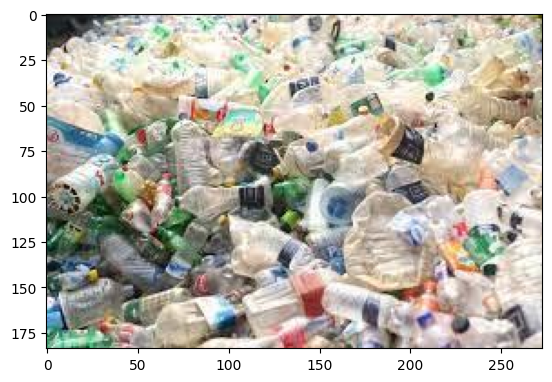

In [ ]:
# Assuming you have the necessary imports and variables
test_image = 'test_image/'
image = "pla.jfif"
image_name = image.split('.')[0]
image_name = image_name + ".jpeg"
new_image_path = os.path.join(root, test_image, image)
new_image = cv.imread(new_image_path, cv.IMREAD_GRAYSCALE)
new_image = cv.resize(new_image, (60, 80), interpolation=cv.INTER_LINEAR)

# New image path
test_image = 'test_image/'
image = "pla.jfif"
image_name = image.split('.')[0]
image_name = image_name + ".jpeg"
new_image_path = os.path.join(root, test_image, image)

# Converting the Image to JPEG
im = Image.open(new_image_path)
rgb_im = im.convert('RGB')
rgb_im.save(os.path.join(root, test_image, image_name))
print("Image saved successfully ...")

# Load and preprocess the new image
X_new = Image.open(os.path.join(root, test_image, image_name))
plt.imshow(X_new)
new_image = cv.imread(new_image_path, cv.IMREAD_GRAYSCALE)
new_image = cv.resize(new_image, (60, 80), interpolation=cv.INTER_LINEAR)


ppcr = 7
ppcc = 7
blur = cv.GaussianBlur(new_image, (7, 7), 1)
fd, hog_features = hog(blur, orientations=5, pixels_per_cell=(ppcr, ppcc), cells_per_block=(2, 2), block_norm='L2', visualize=True, feature_vector=True)
reshaped_features = hog_features.reshape(1, -1)

# Ensure reshaped_features has the same number of features as used for training the logistic regression model
if reshaped_features.shape[1] != logistic_regression_model.coef_.shape[1]:
    reshaped_features = reshaped_features[:, :logistic_regression_model.coef_.shape[1]]

# Scale the features
scaled_features = scaler.transform(reshaped_features)
# Predict the label for the new image using Logistic Regression
logistic_regression_prediction = logistic_regression_model.predict(scaled_features)

# Print the result
print(f"Data={image}, Predicted (Logistic Regression): {logistic_regression_prediction}")



In [ ]:
#Logistic regression Done

 **Random Forest**

In [ ]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [ ]:
rfClassifier = RandomForestClassifier()
rfClassifier.fit(X_train, y_train)
rfClassifier_accuracy = rfClassifier.score(X_test, y_test)
print('Accuracy of the Random Forest Classifier is: ', rfClassifier_accuracy)
print('\n')

cv_scores = cross_val_score(rfClassifier, X_test, y_test, cv=5)
print('Scores from cross-validation is: ', cv_scores)
print('Average accuracy from cross-validation is: {}'.format(np.mean(cv_scores)))
print('\n')

predictions = rfClassifier.predict(X_test)
print('---------- Model evaluation ----------')
print(classification_report(y_test, predictions))

Accuracy of the Random Forest Classifier is:  0.6620813397129187


Scores from cross-validation is:  [0.65836653 0.63210369 0.66301097 0.64307079 0.68095713]
Average accuracy from cross-validation is: 0.6555018212295385


---------- Model evaluation ----------
              precision    recall  f1-score   support

           O       0.68      0.74      0.70      2748
           R       0.64      0.57      0.61      2268

    accuracy                           0.66      5016
   macro avg       0.66      0.65      0.65      5016
weighted avg       0.66      0.66      0.66      5016



In [ ]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

rfClassifier_scaler = RandomForestClassifier()
rfClassifier_scaler.fit(X_scaled_train, y_train)
rfClassifier_accuracy = rfClassifier_scaler.score(X_scaled_test, y_test)
print('Accuracy of the Random Forest Classifier is: ', rfClassifier_accuracy)
print('\n')

cv_scores = cross_val_score(rfClassifier_scaler, X_scaled_test, y_test, cv=5)
print('Scores from cross-validation is: ', cv_scores)
print('Average accuracy from cross-validation is: {}'.format(np.mean(cv_scores)))
print('\n')

predictions = rfClassifier_scaler.predict(X_scaled_test)
print('---------- Model evaluation ----------')
print(classification_report(y_test, predictions))

Accuracy of the Random Forest Classifier is:  0.6720494417862839


Scores from cross-validation is:  [0.66633466 0.63210369 0.666999   0.64506481 0.68693918]
Average accuracy from cross-validation is: 0.6594882682629402


---------- Model evaluation ----------
              precision    recall  f1-score   support

           O       0.68      0.75      0.71      2748
           R       0.66      0.58      0.62      2268

    accuracy                           0.67      5016
   macro avg       0.67      0.66      0.66      5016
weighted avg       0.67      0.67      0.67      5016



In [ ]:
### Tuning hyperparams for the Random Forest Classifier

In [ ]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

rfClassifier_params_1 = RandomForestClassifier(max_features='log2', n_estimators=200)
rfClassifier_params_1.fit(X_scaled_train, y_train)
rfClassifier_accuracy = rfClassifier_params_1.score(X_scaled_test, y_test)
print('Accuracy of the Random Forest Classifier is: ', rfClassifier_accuracy)
print('\n')

cv_scores = cross_val_score(rfClassifier_params_1, X_scaled_test, y_test, cv=5)
print('Scores from cross-validation is: ', cv_scores)
print('Average accuracy from cross-validation is: {}'.format(np.mean(cv_scores)))
print('\n')

predictions = rfClassifier_params_1.predict(X_scaled_test)
print('---------- Model evaluation ----------')
print(classification_report(y_test, predictions))

Accuracy of the Random Forest Classifier is:  0.6668660287081339


Scores from cross-validation is:  [0.67828685 0.64705882 0.65802592 0.65004985 0.68095713]
Average accuracy from cross-validation is: 0.662875715483033


---------- Model evaluation ----------
              precision    recall  f1-score   support

           O       0.68      0.73      0.71      2748
           R       0.64      0.59      0.61      2268

    accuracy                           0.67      5016
   macro avg       0.66      0.66      0.66      5016
weighted avg       0.67      0.67      0.67      5016



In [ ]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

rfClassifier_params_2 = RandomForestClassifier(max_depth=100, max_leaf_nodes=200)
rfClassifier_params_2.fit(X_scaled_train, y_train)
rfClassifier_accuracy = rfClassifier_params_2.score(X_scaled_test, y_test)
print('Accuracy of the Random Forest Classifier is: ', rfClassifier_accuracy)
print('\n')

cv_scores = cross_val_score(rfClassifier_params_2, X_scaled_test, y_test, cv=5)
print('Scores from cross-validation is: ', cv_scores)
print('Average accuracy from cross-validation is: {}'.format(np.mean(cv_scores)))
print('\n')

predictions = rfClassifier_params_2.predict(X_scaled_test)
print('---------- Model evaluation ----------')
print(classification_report(y_test, predictions))

Accuracy of the Random Forest Classifier is:  0.6758373205741627


Scores from cross-validation is:  [0.6752988  0.64705882 0.65902293 0.6560319  0.67198405]
Average accuracy from cross-validation is: 0.6618793023320476


---------- Model evaluation ----------
              precision    recall  f1-score   support

           O       0.69      0.73      0.71      2748
           R       0.65      0.61      0.63      2268

    accuracy                           0.68      5016
   macro avg       0.67      0.67      0.67      5016
weighted avg       0.67      0.68      0.67      5016



Cohen's Kappa for Random Forest Classifier:  0.3416774503498563
Matthews Correlation Coefficient (MCC) for Random Forest Classifier:  0.34237869938719084


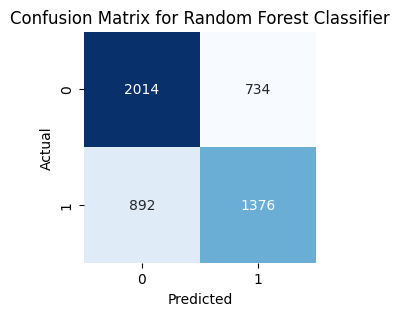

In [ ]:
# Cohen's Kappa statistic
kappa = cohen_kappa_score(y_test, predictions)
print("Cohen's Kappa for Random Forest Classifier: ", kappa)

# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, predictions)
print("Matthews Correlation Coefficient (MCC) for Random Forest Classifier: ", mcc)

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

In [ ]:
# Saved the model using Pickel

with open(os.path.join(root,model,'randomForestClassifiers.pkl'), 'wb') as randomForestPickle:
    pickle.dump(randomForest_classifiers, randomForestPickle)

# Load the model from disk
loaded_model = pickle.load(open(os.path.join(root,model,'randomForestClassifiers.pkl'), 'rb'))

In [ ]:
# Save the trained models to a single pickle file

randomForest_classifiers = {
    'rfClassifier': rfClassifier,
    'rfClassifier_scaler': rfClassifier_scaler,
    'rfClassifier_params_1': rfClassifier_params_1,
    'rfClassifier_params_2': rfClassifier_params_2
}

model_path = 'randomForestClassifiers.pkl'
with open(model_path, 'wb') as model_file:
    pickle.dump(randomForest_classifiers, model_file)

In [ ]:
### SVM with HOG

In [ ]:
from sklearn.preprocessing import StandardScaler

test_accuracy = []
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Initialize an SVM classifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


# Initialize an SVM classifier
svm_hog_clf = SVC(C=1.0, kernel='rbf', gamma='auto')

# Train the SVM model on the training data
svm_hog_clf.fit(X_train, y_train)
print("--------------done SVM-------------------")

# Make predictions on the test set
y_pred = svm_hog_clf.predict(X_test)

# Calculate accuracy for this fold
accuracy = accuracy_score(y_test, y_pred)


# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred)

--------------done SVM-------------------


In [ ]:
def calculate_accuracy_metrics(y_test,y_pred):
  # # Sensitivity (Recall)
  #   sensitivity = recall_score(y_test, y_pred, pos_label=pos)  # or pos_label='O' depending on your positive class
  #   print("Sensitivity (Recall):", sensitivity)

  #   # Precision
  #   precision = precision_score(y_test, y_pred, pos_label=pos)  # or pos_label='O' depending on your positive class
  #   print("Precision:", precision)

  #   # F1-score
  #   f1 = f1_score(y_test, y_pred, pos_label=pos)  # or pos_label='O' depending on your positive class
  #   print("F1-score:", f1)

    sensitivity_overall = recall_score(y_test, y_pred, average='weighted')
    print('sensitivity: ',sensitivity_overall)
    precision_overall = precision_score(y_test, y_pred, average='weighted')
    print('Precision:',precision_overall)
    f1_overall = f1_score(y_test, y_pred, average='weighted')
    print('F1 Score:',f1_overall)

    # Cohen's Kappa statistic
    kappa = cohen_kappa_score(y_test, y_pred)
    print("Cohen's Kappa:", kappa)

    # Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_test, y_pred)
    print("Matthews Correlation Coefficient (MCC):", mcc)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

Test Accuracy: 67.76%
sensitivity:  0.6776315789473685
Precision: 0.6784913458081604
F1 Score: 0.6779613574166947
Cohen's Kappa: 0.35082944032947105
Matthews Correlation Coefficient (MCC): 0.35093468950348944


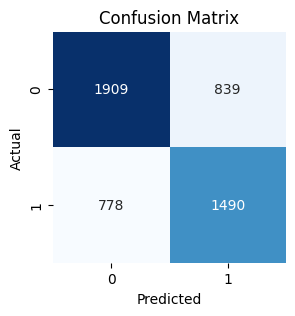

In [ ]:
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
calculate_accuracy_metrics(y_test, y_pred)

In [91]:
# Applying PCA as the results were not good
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
n_components = 2000
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Initialize an SVM classifier
svm_hog_clf = SVC(C=1.0, kernel='rbf', gamma='auto')
# Train the SVM model on the training data
svm_hog_clf.fit(X_train_pca, y_train)
# Make predictions on the test set
y_pred = svm_hog_clf.predict(X_test_pca)


Test Accuracy: 70.95%
sensitivity:  0.7095295055821371
Precision: 0.7128154644968367
F1 Score: 0.7101666031052244
Cohen's Kappa: 0.4179263388078417
Matthews Correlation Coefficient (MCC): 0.4191227817496338


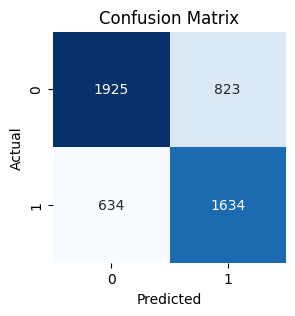

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

calculate_accuracy_metrics(y_test, y_pred)

In [ ]:
# Saved the model using Pickel

with open(os.path.join(root,model,'svm_hog_model.pkl'), 'wb') as svmHogPickle:
    pickle.dump(svm_hog_clf, svmHogPickle)

# Load the model from disk
loaded_model = pickle.load(open(os.path.join(root,model,'svm_hog_model.pkl'), 'rb'))


Image saved successfully ...
Predicted Class: ['O']


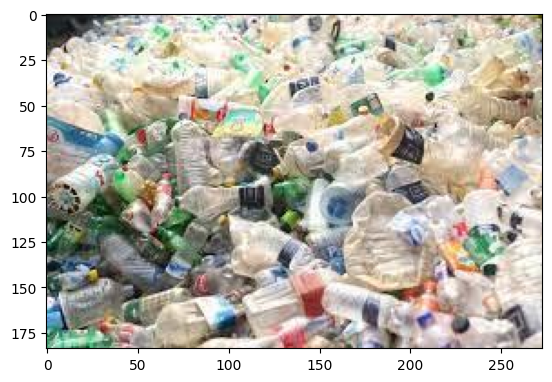

In [ ]:
#  new image path

test_image = 'test_image/'
image = "pla.jfif"
image_name = image.split('.')[0]
image_name = image_name + ".jpeg"
new_image_path = root + "/" + test_image + image
# Converting the Image to JPEG

im = Image.open(os.path.join(root, test_image, image))
rgb_im = im.convert('RGB')
rgb_im.save(os.path.join(root, test_image, image_name))
print("Image saved successfully ...")

# Load and preprocess the new image
X_new = Image.open(os.path.join(root,test_image,image_name))
plt.imshow(X_new)
new_image = cv.imread(new_image_path, cv.IMREAD_GRAYSCALE)
new_image = cv.resize(new_image, (60, 80), interpolation=cv.INTER_LINEAR)  # Resize if needed
# Extract HOG features
ppcr = 7
ppcc = 7
blur = cv.GaussianBlur(new_image, (7, 7), 1)
fd, hog_features = hog(blur, orientations=5, pixels_per_cell=(ppcr, ppcc), cells_per_block=(2, 2), block_norm='L2', visualize=True)
stacked_features = np.stack([hog_features], axis=0)
reshaped_features = stacked_features.reshape((1, -1))
if reshaped_features.shape[1] != X_train.shape[1]:
    reshaped_features = reshaped_features[:, :X_train.shape[1]]

new_image_scaled = scaler.transform(reshaped_features)
new_image_pca = pca.transform(new_image_scaled)
predicted_class = svm_hog_clf.predict(new_image_pca)

predicted_class = svm_hog_clf.predict(new_image_pca)
# label = predict_classification(dataset, row, num_neighbors)


print("Predicted Class:", predicted_class)

In [ ]:
#  new image path

test_image = 'test_image/'
image = "O_13828.jpg"
image_name = image.split('.')[0]
image_name = image_name + ".jpeg"
new_image_path = root + "/" + test_image + image
# Converting the Image to JPEG

im = Image.open(os.path.join(root, test_image, image))
rgb_im = im.convert('RGB')
rgb_im.save(os.path.join(root, test_image, image_name))
print("Image saved successfully ...")

# Load and preprocess the new image
X_new = Image.open(os.path.join(root,test_image,image_name))
plt.imshow(X_new)
new_image = cv.imread(new_image_path, cv.IMREAD_GRAYSCALE)
new_image = cv.resize(new_image, (60, 80), interpolation=cv.INTER_LINEAR)  # Resize if needed
# Extract HOG features
ppcr = 7
ppcc = 7
blur = cv.GaussianBlur(new_image, (7, 7), 1)
fd, hog_features = hog(blur, orientations=5, pixels_per_cell=(ppcr, ppcc), cells_per_block=(2, 2), block_norm='L2', visualize=True)
stacked_features = np.stack([hog_features], axis=0)
reshaped_features = stacked_features.reshape((1, -1))
if reshaped_features.shape[1] != X_train.shape[1]:
    reshaped_features = reshaped_features[:, :X_train.shape[1]]

new_image_scaled = scaler.transform(reshaped_features)
new_image_pca = pca.transform(new_image_scaled)
predicted_class = svm_hog_clf.predict(new_image_pca)

predicted_class = svm_hog_clf.predict(new_image_pca)
# label = predict_classification(dataset, row, num_neighbors)


print("Predicted Class:", predicted_class)